In [3]:
import pandas as pd

# Load the CSV file
file_path = 'sp500_historical_data.csv'
sp500_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
sp500_data.head()
# Convert 'Date' to datetime
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])

# Calculate the running maximum
sp500_data['Running Max'] = sp500_data['Real Total Return Price'].cummax()

# Calculate drawdown in percentage
sp500_data['Drawdown'] = (sp500_data['Real Total Return Price'] - sp500_data['Running Max']) / sp500_data['Running Max'] * 100

# Identify periods with drawdown >= 30%
drawdown_threshold = -50
sp500_data['Drawdown 30%+'] = sp500_data['Drawdown'] <= drawdown_threshold

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Convert 'Date' to datetime
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
# sp500_data['Real Total Return Price']= sp500_data['Close']
# Calculate the running maximum
sp500_data['CumSum']  = (sp500_data['Real Total Return Price'] - sp500_data['Real Total Return Price'].iloc[0]) / sp500_data['Real Total Return Price'].iloc[0] * 100
# sp500_data['Real Total Return Price']= sp500_data['CumSum']
sp500_data['Running Max'] = sp500_data['Real Total Return Price'].cummax()
# sp500_data['Running Max'] = sp500_data['Real Total Return Price'].cummax()

# Calculate drawdown in percentage
sp500_data['Drawdown'] = (sp500_data['Real Total Return Price'] - sp500_data['Running Max']) / sp500_data['Running Max'] * 100

# Identify periods with drawdown >= 30%
drawdown_threshold = -30
sp500_data['Drawdown 30%+'] = sp500_data['Drawdown'] <= drawdown_threshold
sp500_data=sp500_data.dropna()
# Calculate drawdown duration
drawdown_start = None
drawdown_durations = []
for index, row in sp500_data.iterrows():
    if row['Drawdown 30%+'] and drawdown_start is None:
        drawdown_start = index
    elif not row['Drawdown 30%+'] and drawdown_start is not None:
        duration = index - drawdown_start
        drawdown_durations.append((sp500_data.loc[drawdown_start, 'Date'], sp500_data.loc[index-1, 'Date'], duration))
        drawdown_start = None

# Check if the last drawdown is still ongoing
if drawdown_start is not None:
    duration = len(sp500_data) - drawdown_start
    drawdown_durations.append((sp500_data.loc[drawdown_start, 'Date'], sp500_data.iloc[-1]['Date'], duration))

drawdown_durations


[(Timestamp('1974-07-05 00:00:00'), Timestamp('1974-07-22 00:00:00'), 12),
 (Timestamp('1974-07-25 00:00:00'), Timestamp('1975-03-06 00:00:00'), 155),
 (Timestamp('1975-03-12 00:00:00'), Timestamp('1975-03-13 00:00:00'), 2),
 (Timestamp('1975-03-20 00:00:00'), Timestamp('1975-04-10 00:00:00'), 15),
 (Timestamp('1975-08-20 00:00:00'), Timestamp('1975-08-21 00:00:00'), 2),
 (Timestamp('1975-08-26 00:00:00'), Timestamp('1975-08-26 00:00:00'), 1),
 (Timestamp('1975-09-10 00:00:00'), Timestamp('1975-09-18 00:00:00'), 7),
 (Timestamp('1975-09-30 00:00:00'), Timestamp('1975-10-02 00:00:00'), 3),
 (Timestamp('1987-10-19 00:00:00'), Timestamp('1987-10-19 00:00:00'), 1),
 (Timestamp('1987-10-26 00:00:00'), Timestamp('1987-10-28 00:00:00'), 3),
 (Timestamp('1987-11-30 00:00:00'), Timestamp('1987-12-08 00:00:00'), 7),
 (Timestamp('1987-12-10 00:00:00'), Timestamp('1987-12-11 00:00:00'), 2),
 (Timestamp('2001-09-17 00:00:00'), Timestamp('2001-10-02 00:00:00'), 12),
 (Timestamp('2001-10-08 00:00:00'

In [5]:
sp500_data.shape

(13604, 14)

[763, 4446, 7617, 9508, 12609]
[]
[2656, 4930, 9416, 10879, 12735]


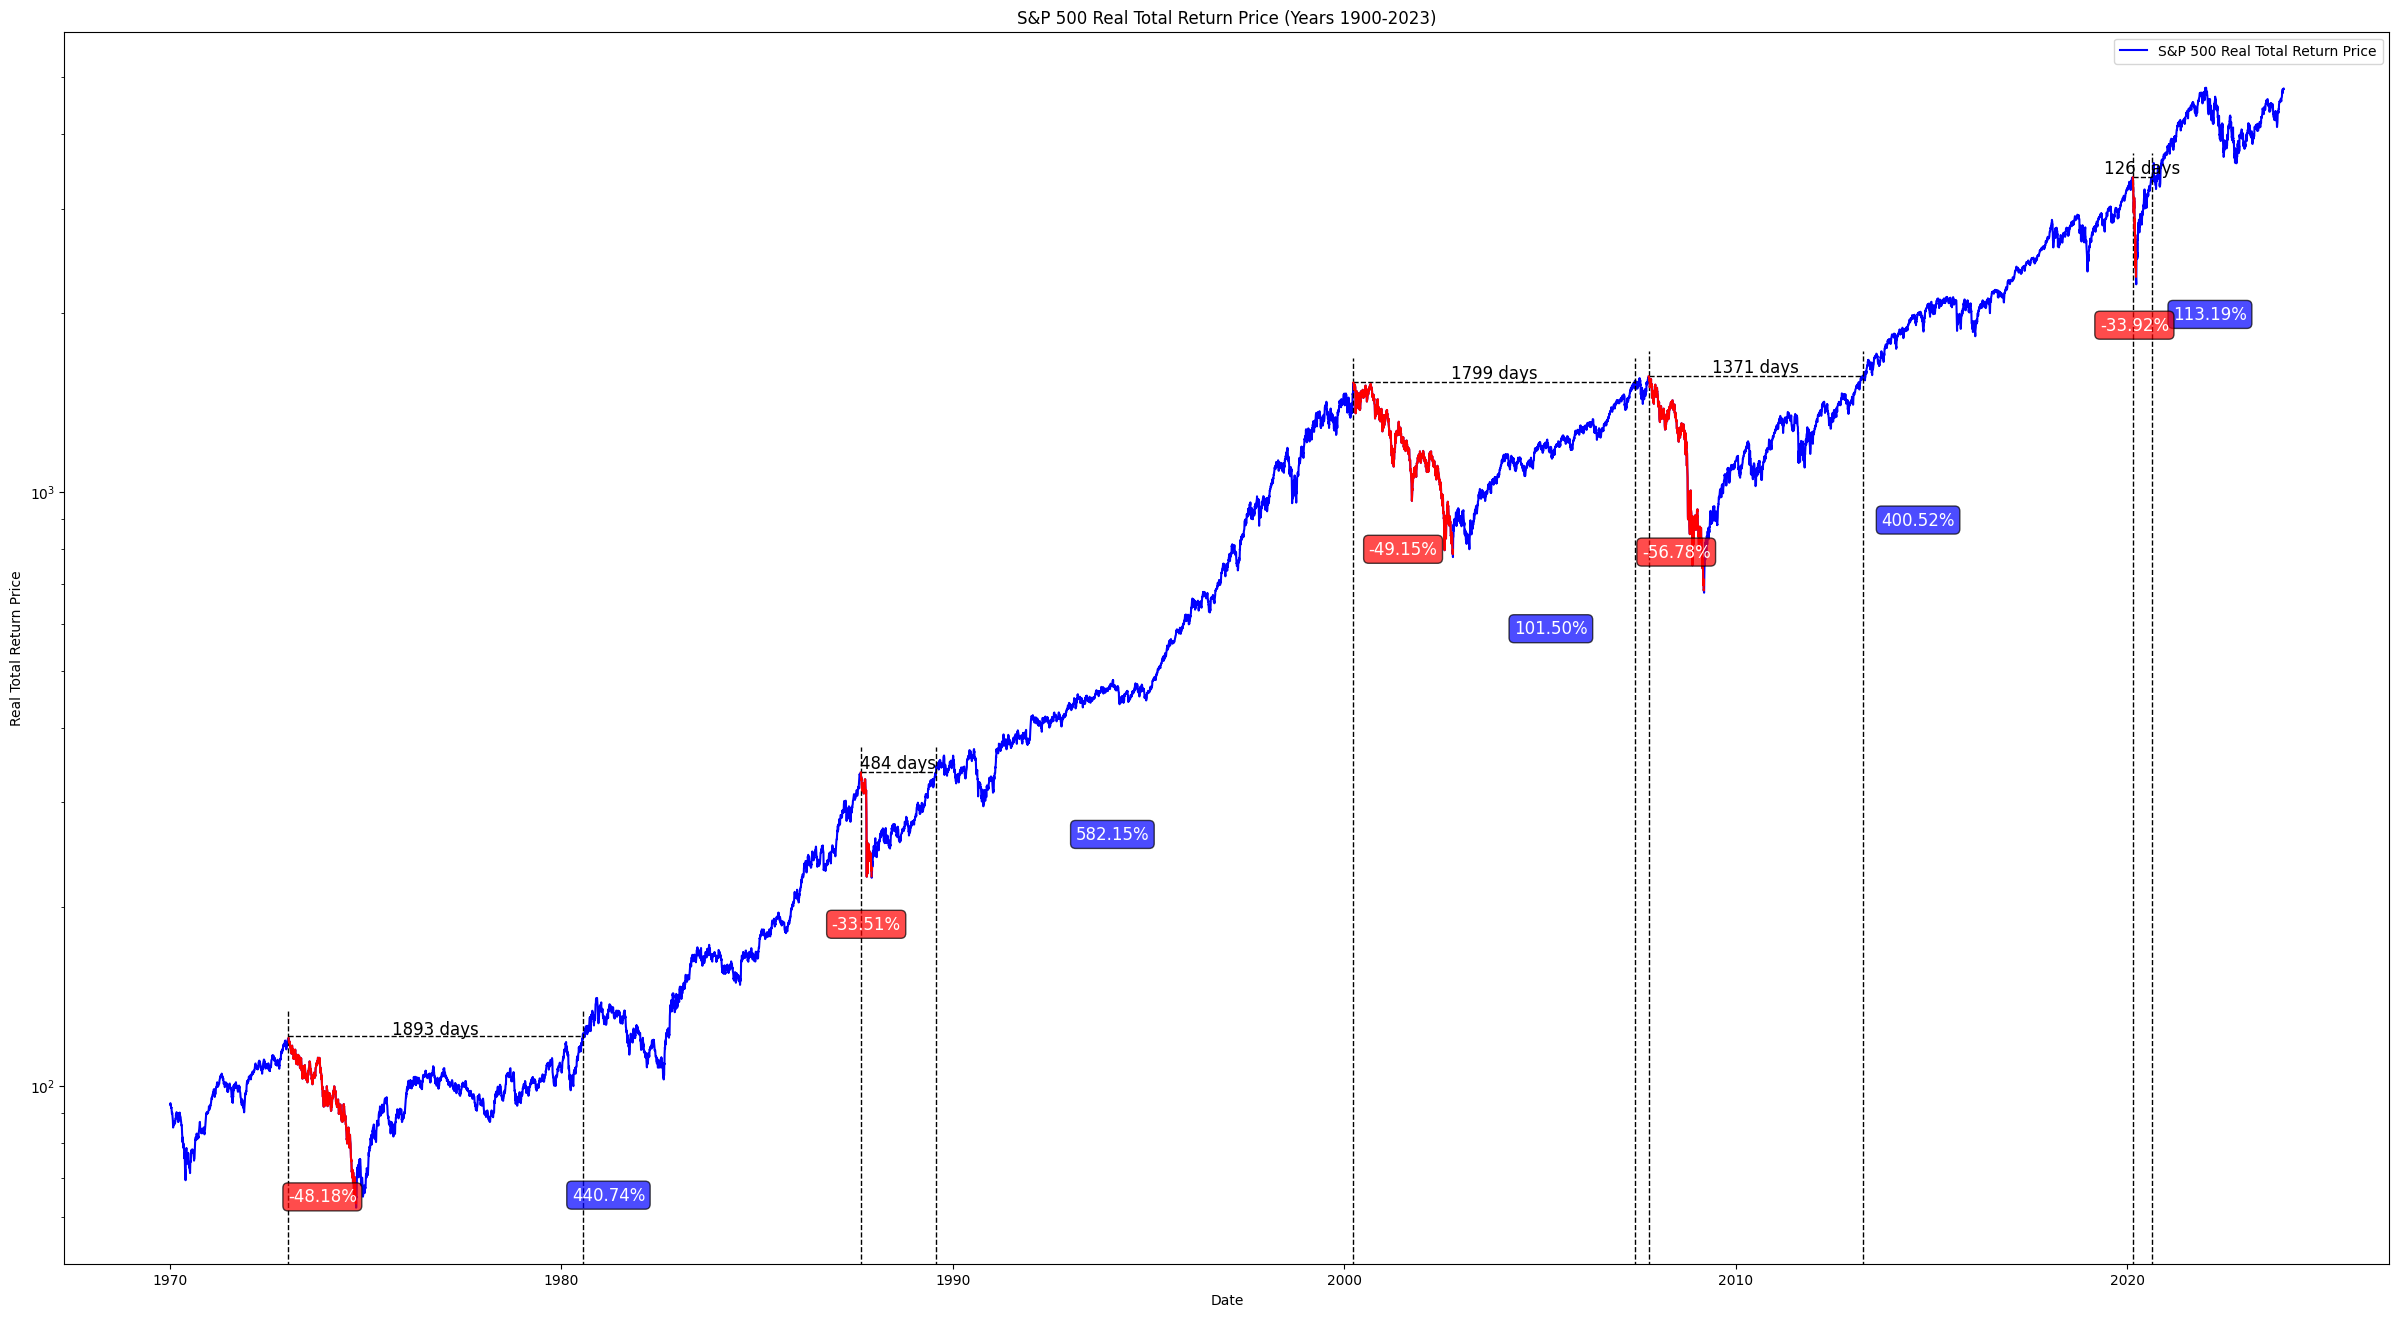

In [6]:

import pandas as pd

# Load the CSV file
# file_path = 'S&P500RealReturns.csv'
# sp500_data = pd.read_csv(file_path)

# # Display the first few rows of the dataframe to understand its structure
# sp500_data.head()
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
# Function to plot each 30-year period starting from 1900 with text annotation for all drawdowns
def plot_annotated_30_year_periods(sp500_data, start_year, end_year):
    """
    Plots the S&P 500 Real Total Return Price for a 30-year period starting from 1900.
    Highlights entire drawdown periods in red, annotates the duration of all drawdowns, and continues until recovery back to the pre-drawdown peak.
    """
    period_data = sp500_data[(sp500_data['Date'].dt.year >= start_year) & (sp500_data['Date'].dt.year <= end_year)]
    # print(period_data.shape[0])
    plt.figure(figsize=(30, 16))
    plt.yscale('log')
    plt.plot(period_data['Date'], period_data['Real Total Return Price'], label='S&P 500 Real Total Return Price', color="blue")

    # Initialize variables to track drawdowns and recovery
    drawdown_start = None
    peak_before_drawdown = None
    index_of_first_occurrence = None
    low_index = None  # Initialize to None
    
    drawdown_start_indexs = []
    low_indexs=[]
    end_indexes = []
    for index, row in period_data.iterrows():
        if row['Drawdown 30%+'] and drawdown_start is None:
            # Drawdown starts
            bottom_index = index
            index_of_first_occurrence = (period_data['Running Max'] == row['Running Max']).idxmax()
            drawdown_start = index_of_first_occurrence
            if drawdown_start not in drawdown_start_indexs:
                drawdown_start_indexs.append(drawdown_start)
                # print(row)
            peak_before_drawdown = period_data.loc[index, 'Running Max']
            start_date = row["Date"].strftime("%m/%y")
        elif drawdown_start is not None and row['Real Total Return Price'] >= peak_before_drawdown:
            # Drawdown ends (price recovers to the pre-drawdown peak)
            end_date = row["Date"].strftime("%m/%y")
            duration = index - drawdown_start
            end_indexes.append(index)
            mid_point = period_data.loc[index_of_first_occurrence:index-1, 'Date'].mean()
            low_point_series = period_data.iloc[index_of_first_occurrence:drawdown_start-1]['Real Total Return Price']
            
            plt.text(mid_point, peak_before_drawdown, f'{duration} days', fontsize=12, ha='center', va='bottom', color='black')
            
            
            # plt.text(period_data.loc[index, 'Date'], peak_before_drawdown*1.3, f'{end_date}', fontsize=10, ha='left', va='top', color='black')
            # plt.text(period_data.loc[drawdown_start, 'Date'], peak_before_drawdown*1.3, f'{start_date}', fontsize=10, ha='right', va='top', color='black')
            
            plt.hlines(y=row['Real Total Return Price'] , xmin=period_data.loc[drawdown_start-1, 'Date'], xmax=period_data.loc[index, 'Date'], colors='black', linestyles='dashed', lw=1)
            plt.vlines(x=period_data.loc[drawdown_start-1, 'Date'], ymin=0, ymax=row['Real Total Return Price']*1.1, colors='black', linestyles='dashed', lw=1)
            plt.vlines(x=period_data.loc[index, 'Date'], ymin=0, ymax=row['Real Total Return Price']*1.1, colors='black', linestyles='dashed', lw=1)

            drawdown_start = None
            peak_before_drawdown = None
    print(drawdown_start_indexs)
    print(low_indexs)
    print(end_indexes)
    
    for index,value in enumerate(drawdown_start_indexs):
        # print(index,len(drawdown_start_indexs))
        start_index  = value
        end_index = end_indexes[index]
        minVal=period_data.loc[start_index:end_index,'Real Total Return Price'].idxmin()
        # print(start_index,end_index)
        if index == 0:
            # plt.fill_between(period_data.loc[0:start_index-1, 'Date'], period_data.loc[0:start_index-1, 'Real Total Return Price'], color='blue', alpha=0.3)
            pass
        if index == len(drawdown_start_indexs)-1:
            new_index= period_data.index[-1]
            
        else:
            new_index = drawdown_start_indexs[index+1]
            
        # if index+1 < len(drawdown_start_indexs):
        
        end_index = end_indexes[index]
        minVal = period_data.loc[start_index:end_index, 'Real Total Return Price'].idxmin()

#         if index == 0:
#             plt.fill_between(period_data.loc[0:start_index-1, 'Date'], period_data.loc[0:start_index-1, 'Real Total Return Price'], color='blue', alpha=0.3)
#         if index == len(drawdown_start_indexs) - 1:
#             new_index = period_data.index[-1]
#         else:
#             new_index = drawdown_start_indexs[index+1]
        
        # Fill blue section
        blue_start_price = period_data.loc[minVal, 'Real Total Return Price']
        blue_end_price = period_data.loc[new_index, 'Real Total Return Price']
        blue_return = (blue_end_price - blue_start_price) / blue_start_price * 100
        # plt.fill_between(period_data.loc[minVal:new_index-1, 'Date'], period_data.loc[minVal:new_index-1, 'Real Total Return Price'], color='blue', alpha=0.3)
        blue_mid_point_x = period_data.loc[minVal:new_index-1, 'Date'].mean()
        # blue_mid_point_y = period_data.loc[minVal:new_index-1, 'Real Total Return Price'].mean()
        # plt.text(blue_mid_point_x, blue_mid_point_y, f'{blue_return:.2f}%', fontsize=12, ha='center', va='center', color='black')
        
        # Fill red section
        red_start_price = period_data.loc[start_index, 'Real Total Return Price']
        red_end_price = period_data.loc[minVal, 'Real Total Return Price']
        red_return = (red_end_price - red_start_price) / red_start_price * 100
        # plt.fill_between(period_data.loc[start_index:minVal-1, 'Date'], period_data.loc[start_index:minVal-1, 'Real Total Return Price'], color='red', alpha=0.7)
        red_mid_point = period_data.loc[start_index:minVal-1, 'Date'].mean()
        # blue_mid_point_y = period_data.loc[minVal:new_index-1, 'Real Total Return Price'].mean()
        # plt.text(red_mid_point, blue_mid_point_y, f'{red_return:.2f}%', fontsize=12, ha='center', va='center', color='white')                
        
        blue_y_values = period_data.loc[minVal:new_index-1, 'Real Total Return Price']
        blue_mid_point_y = np.exp(np.mean(np.log(blue_y_values)))/2

        red_y_values = period_data.loc[start_index:minVal-1, 'Real Total Return Price']
        red_mid_point_y = np.exp(np.mean(np.log(red_y_values)))/1.5
        text_props_red = dict(boxstyle='round', facecolor='red', alpha=0.7)
        text_props_blue = dict(boxstyle='round', facecolor='blue', alpha=0.7)
# Now use blue_mid_point_y and red_mid_point_y for placing text
        plt.text(blue_mid_point_x, blue_mid_point_y, f'{blue_return:.2f}%', fontsize=12, ha='center', va='center', color='white',bbox=text_props_blue)
        plt.text(red_mid_point, red_mid_point_y, f'{red_return:.2f}%', fontsize=12, ha='center', va='center', color='white',bbox=text_props_red)
        # plt.fill_between(period_data.loc[minVal:new_index-1, 'Date'], period_data.loc[minVal:new_index-1, 'Real Total Return Price'], color='blue', alpha=0.3)
        # plt.fill_between(period_data.loc[start_index:minVal-1, 'Date'], period_data.loc[start_index:minVal-1, 'Real Total Return Price'], color='red', alpha=0.7)
        # print(minVal)
        plt.plot(period_data.loc[start_index:minVal-1, 'Date'],
                      period_data.loc[start_index:minVal-1, 'Real Total Return Price'],
                     color='red')    
        
    # plt.fill_between(period_data.loc[drawdown_start_indexs[-1]:end_indexes[-1], 'Date'], period_data.loc[drawdown_start_indexs[-1]:end_indexes[-1], 'Real Total Return Price'], color='red', alpha=0.3)
    # for index, start_index in enumerate(drawdown_start_indexes):



    # plt.fill_between(period_data['Date'], period_data['Real Total Return Price'], where=~period_data['Drawdown 30%+'], color='white', alpha=0.3, label='Other Periods')
    plt.title(f'S&P 500 Real Total Return Price (Years {start_year}-{end_year})')
    plt.xlabel('Date')
    plt.ylabel('Real Total Return Price')
    plt.legend()
    # plt.grid(True)
    plt.savefig('Drawdowns-Log.png')
    plt.show()

# Plot each 30-year period starting from 1900 with text annotation for all drawdowns
start_year = 1900
end_year = min(start_year+123, 2023)
plot_annotated_30_year_periods(sp500_data, start_year, end_year)
# for start_year in range(start_year, 1980, 123):



[763, 4446, 7617, 9508, 12609]
[]
[2656, 4930, 9416, 10879, 12735]
Start:11/01/73
End:17/07/80
minVal:03/10/74
NewIndex:25/08/87
----------
{'Peak Date': '11/01/1973', 'Low Date': '03/10/1974', 'Loss Period': 630, 'Loss %': -48.18, 'Recovery Date': '17/07/1980', 'Recovery Period': 2114, 'Recovery %': 92.98256661536053, 'Total Duration': 2744}
Start:25/08/87
End:26/07/89
minVal:04/12/87
NewIndex:24/03/00
----------
{'Peak Date': '25/08/1987', 'Low Date': '04/12/1987', 'Loss Period': 101, 'Loss %': -33.51, 'Recovery Date': '26/07/1989', 'Recovery Period': 600, 'Recovery %': 50.397459703256345, 'Total Duration': 701}
Start:24/03/00
End:30/05/07
minVal:09/10/02
NewIndex:09/10/07
----------
{'Peak Date': '24/03/2000', 'Low Date': '09/10/2002', 'Loss Period': 929, 'Loss %': -49.15, 'Recovery Date': '30/05/2007', 'Recovery Period': 1694, 'Recovery %': 96.64503086331476, 'Total Duration': 2623}
Start:09/10/07
End:28/03/13
minVal:09/03/09
NewIndex:19/02/20
----------
{'Peak Date': '09/10/2007',

[{'type': 'rect',
  'xref': 'x',
  'yref': 'y',
  'x0': '1973/01/11/',
  'y0': 120.18954013230233,
  'x1': '1974/10/03/',
  'y1': 62.27999877929688,
  'fillcolor': '#FF0000',
  'opacity': 0.2,
  'line': {'width': 0}},
 {'type': 'line',
  'x0': '1973/01/11/',
  'y0': 120.18954013230233,
  'x1': '1980/07/17/',
  'y1': 120.18954013230233,
  'line': {'color': 'rgb(0, 0, 0)', 'width': 2, 'dash': 'dash'},
  'label': {'text': '2744 Days', 'yanchor': 'bottom'}},
 {'type': 'line',
  'x0': '1974/10/03/',
  'y0': 62.27999877929688,
  'x1': '1980/07/17/',
  'y1': 62.27999877929688,
  'line': {'color': 'rgb(0, 0, 0)', 'width': 2, 'dash': 'dash'},
  'label': {'text': '2114 Days', 'yanchor': 'bottom'}},
 {'type': 'rect',
  'xref': 'x',
  'yref': 'y',
  'x0': '1987/08/25/',
  'y0': 336.7699890136719,
  'x1': '1987/12/04/',
  'y1': 223.9199981689453,
  'fillcolor': '#FF0000',
  'opacity': 0.2,
  'line': {'width': 0}},
 {'type': 'line',
  'x0': '1987/08/25/',
  'y0': 336.7699890136719,
  'x1': '1989/07/

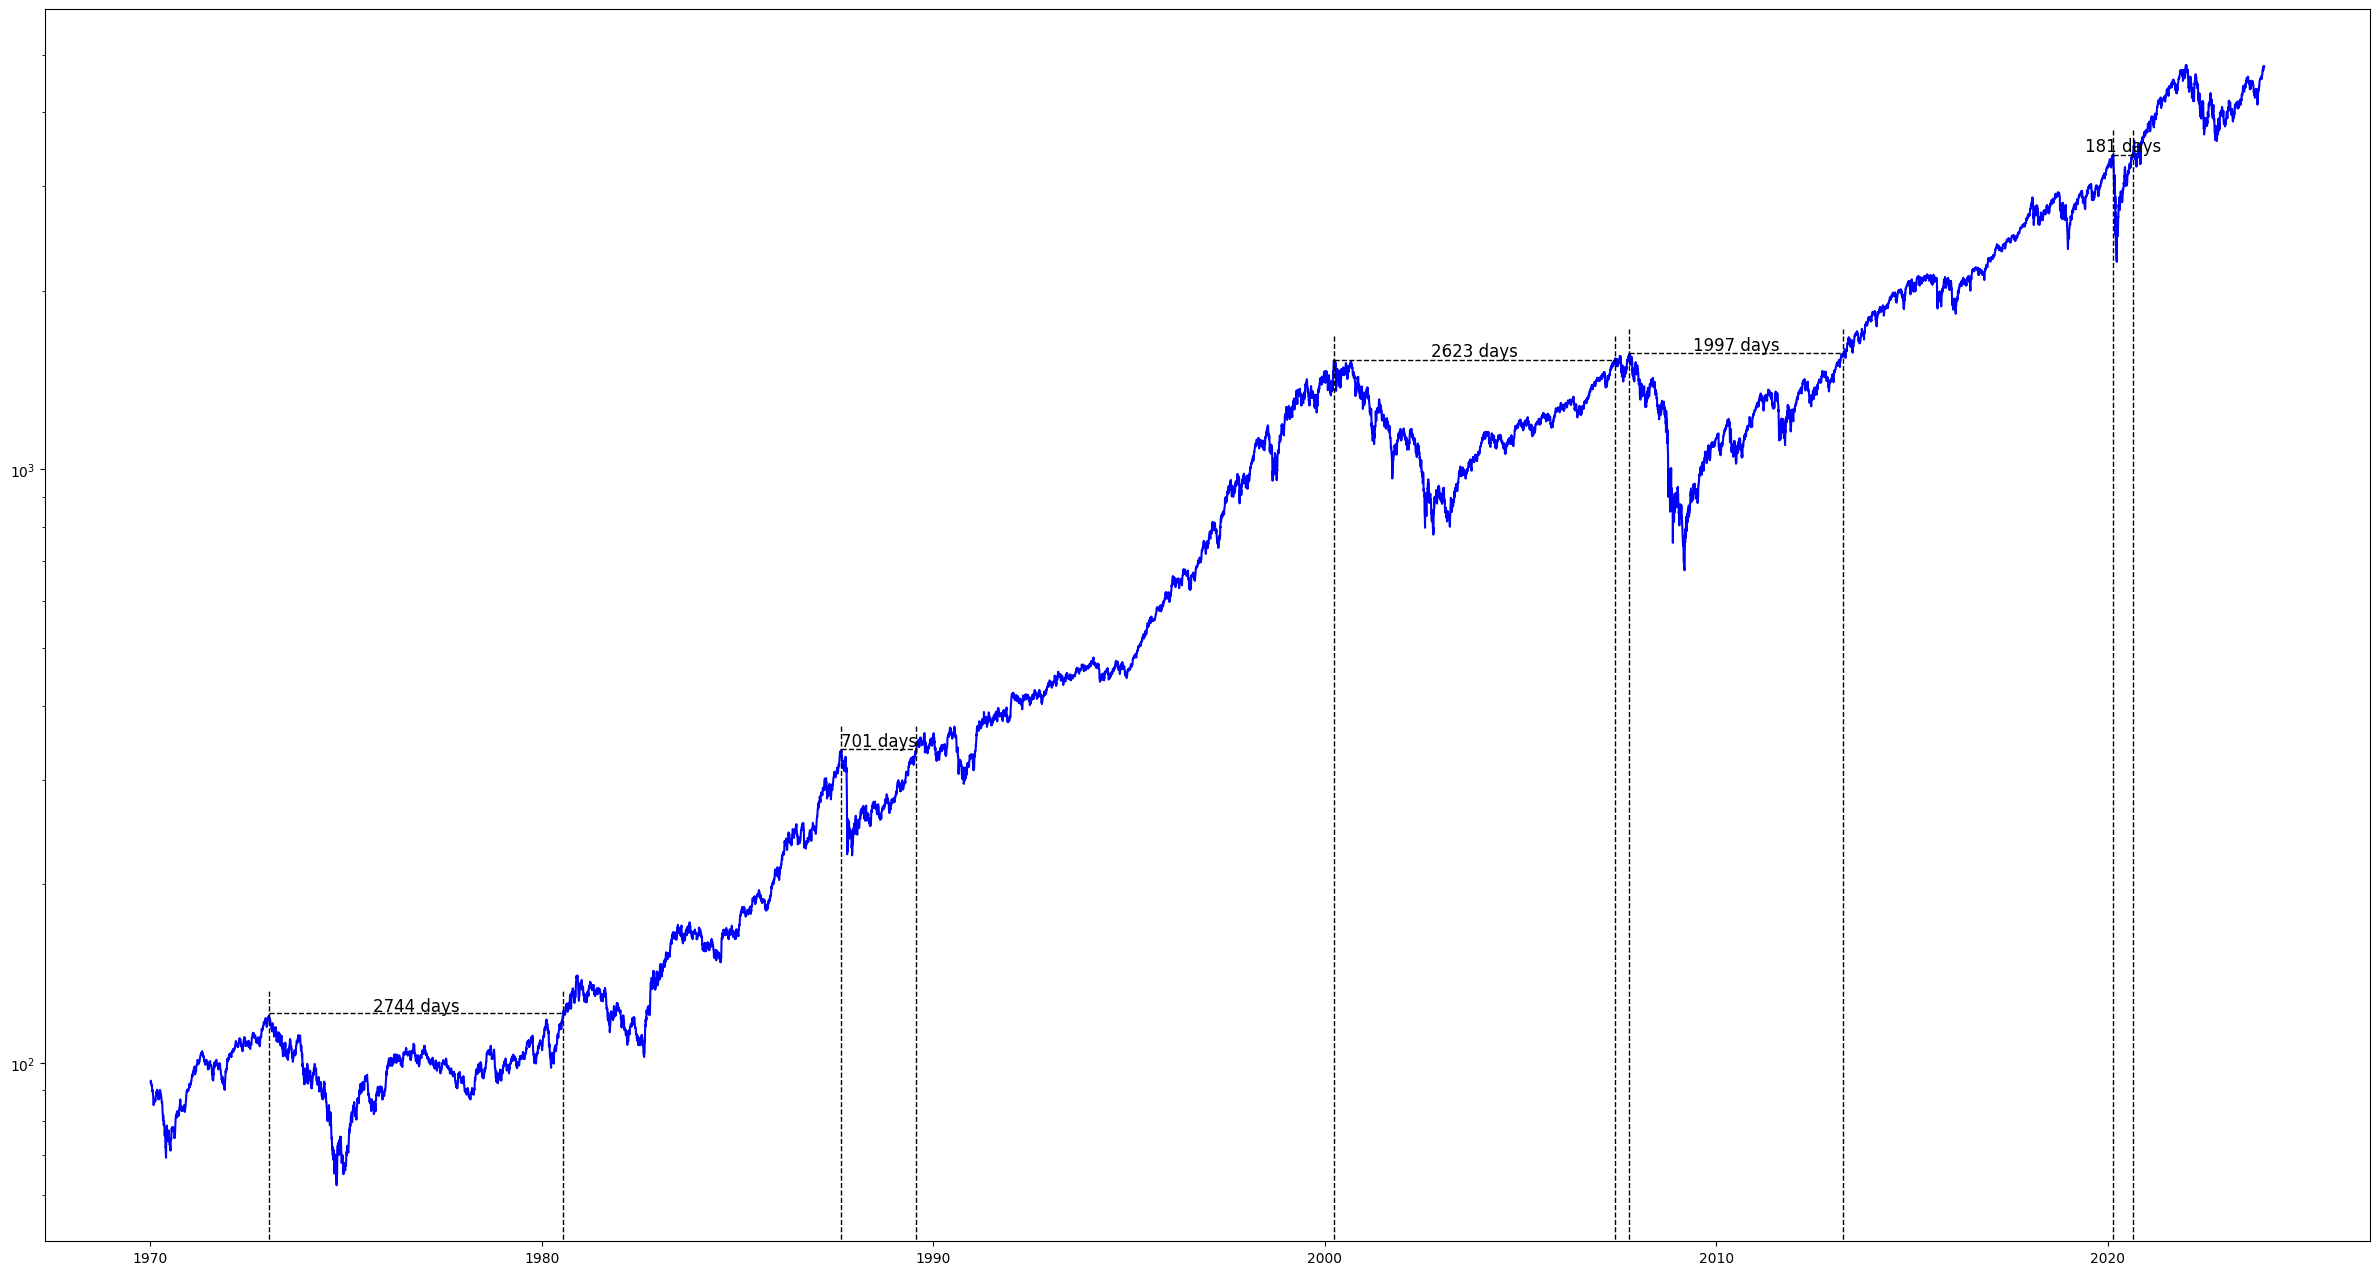

In [9]:

import pandas as pd

# Load the CSV file
# file_path = 'S&P500RealReturns.csv'
# sp500_data = pd.read_csv(file_path)

# # Display the first few rows of the dataframe to understand its structure
# sp500_data.head()
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
info = []
shapes = [] 
# Function to plot each 30-year period starting from 1900 with text annotation for all drawdowns
def createShapes(sp500_data, start_year, end_year):
    """
    Plots the S&P 500 Real Total Return Price for a 30-year period starting from 1900.
    Highlights entire drawdown periods in red, annotates the duration of all drawdowns, and continues until recovery back to the pre-drawdown peak.
    """
    period_data = sp500_data[(sp500_data['Date'].dt.year >= start_year) & (sp500_data['Date'].dt.year <= end_year)]
    # print(period_data.shape[0])
    plt.figure(figsize=(30, 16))
    plt.yscale('log')
    plt.plot(period_data['Date'], period_data['Real Total Return Price'], label='S&P 500 Real Total Return Price', color="blue")

    # Initialize variables to track drawdowns and recovery
    drawdown_start = None
    peak_before_drawdown = None
    index_of_first_occurrence = None
    low_index = None  # Initialize to None
    
    drawdown_start_indexs = []
    low_indexs=[]
    end_indexes = []
    for index, row in period_data.iterrows():
        if row['Drawdown 30%+'] and drawdown_start is None:
            # Drawdown starts
            bottom_index = index
            index_of_first_occurrence = (period_data['Running Max'] == row['Running Max']).idxmax()
            drawdown_start = index_of_first_occurrence
            if drawdown_start not in drawdown_start_indexs:
                drawdown_start_indexs.append(drawdown_start)
                # print(row)
            peak_before_drawdown = period_data.loc[index, 'Running Max']
            start_date = row["Date"].strftime("%m/%y")
        elif drawdown_start is not None and row['Real Total Return Price'] >= peak_before_drawdown:
            # Drawdown ends (price recovers to the pre-drawdown peak)
            end_date = row["Date"].strftime("%m/%y")
            duration = period_data.loc[index]['Date'] - period_data.loc[drawdown_start]['Date']
            end_indexes.append(index)
            mid_point = period_data.loc[index_of_first_occurrence:index-1, 'Date'].mean()
            low_point_series = period_data.iloc[index_of_first_occurrence:drawdown_start-1]['Real Total Return Price']
            
            plt.text(mid_point, peak_before_drawdown, f'{duration.days} days', fontsize=12, ha='center', va='bottom', color='black')
            plt.hlines(y=row['Real Total Return Price'] , xmin=period_data.loc[drawdown_start-1, 'Date'], xmax=period_data.loc[index, 'Date'], colors='black', linestyles='dashed', lw=1)
            plt.vlines(x=period_data.loc[drawdown_start-1, 'Date'], ymin=0, ymax=row['Real Total Return Price']*1.1, colors='black', linestyles='dashed', lw=1)
            plt.vlines(x=period_data.loc[index, 'Date'], ymin=0, ymax=row['Real Total Return Price']*1.1, colors='black', linestyles='dashed', lw=1)

            drawdown_start = None
            peak_before_drawdown = None
    print(drawdown_start_indexs)
    print(low_indexs)
    print(end_indexes)
    
    for index,value in enumerate(drawdown_start_indexs):
        # print(index,len(drawdown_start_indexs))
        start_index  = value
        end_index = end_indexes[index]
        minVal=period_data.loc[start_index:end_index,'Real Total Return Price'].idxmin()
        # print(start_index,end_index)
        if index == 0:
            # plt.fill_between(period_data.loc[0:start_index-1, 'Date'], period_data.loc[0:start_index-1, 'Real Total Return Price'], color='blue', alpha=0.3)
            pass
        if index == len(drawdown_start_indexs)-1:
            new_index= period_data.index[-1]
            
        else:
            new_index = drawdown_start_indexs[index+1]
            
        # if index+1 < len(drawdown_start_indexs):
        
        end_index = end_indexes[index]
        minVal = period_data.loc[start_index:end_index, 'Real Total Return Price'].idxmin()
        print('Start:'+period_data.loc[start_index, 'Date'].strftime("%d/%m/%y"))
        print('End:'+period_data.loc[end_index, 'Date'].strftime("%d/%m/%y"))
        print('minVal:'+period_data.loc[minVal, 'Date'].strftime("%d/%m/%y"))
        print('NewIndex:'+period_data.loc[new_index, 'Date'].strftime("%d/%m/%y"))
        
        
        print('----------')
        peakValue = period_data.loc[start_index, 'Real Total Return Price']
        lowValue = period_data.loc[minVal, 'Real Total Return Price']
        RecvoveryValue = period_data.loc[end_index, 'Real Total Return Price']
        
        peakDate = period_data.loc[start_index, 'Date']
        lowDate = period_data.loc[minVal, 'Date']
        RecvoveryDate = period_data.loc[end_index, 'Date']
        
        lossDelta =lowDate- peakDate
        LossPeriod= lossDelta.days
        LossPer = round(((peakValue-lowValue)/peakValue)*100,2)
    
        
        reoveryDelta =RecvoveryDate- lowDate
        recvoveryPeriod = reoveryDelta.days
        recoveryPer = ((lowValue-peakValue)/lowValue)*100
        
        totalPeroid =LossPeriod + recvoveryPeriod
        
        
        PeakDateString = peakDate.strftime("%Y/%m/%d/")
        LowDateString = lowDate.strftime("%Y/%m/%d/")
        RecoveryDateString = RecvoveryDate.strftime("%Y/%m/%d/")
        
        res = {
            'Peak Date':peakDate.strftime("%d/%m/%Y"),
            'Low Date':lowDate.strftime("%d/%m/%Y"),
            'Loss Period':LossPeriod,
            'Loss %':-LossPer,
            'Recovery Date':RecvoveryDate.strftime("%d/%m/%Y"),
            'Recovery Period':recvoveryPeriod,
            'Recovery %':-recoveryPer,
            'Total Duration':totalPeroid
              }
        info.append(res)
        print(res)
        
        shape = {
        'type': 'rect',
        'xref': 'x',
        'yref': 'y',
        'x0': PeakDateString,
        'y0': peakValue,
        'x1': LowDateString,
        'y1': lowValue,
        'fillcolor': '#FF0000',
        'opacity': 0.2,
        'line': {
            'width': 0
            }
        }
        shapes.append(shape)
        
        recoveryLine =   {
        'type': 'line',
        'x0': PeakDateString,
        'y0': peakValue,
        'x1': RecoveryDateString,
        'y1':peakValue,
        'line': {
          'color': 'rgb(0, 0, 0)',
          'width': 2,
          'dash': 'dash'
        },
        'label': {
          'text': str(totalPeroid)+' Days',
          'yanchor': 'bottom',
        },

        }
        shapes.append(recoveryLine)
        
        recoveryLine =   {
        'type': 'line',
        'x0': LowDateString,
        'y0': lowValue,
        'x1': RecoveryDateString,
        'y1':lowValue,
        'line': {
          'color': 'rgb(0, 0, 0)',
          'width': 2,
          'dash': 'dash'
        },
        'label': {
          'text': str(recvoveryPeriod)+' Days',
          'yanchor': 'bottom',
        },

        }
        shapes.append(recoveryLine)
    return shapes

# Plot each 30-year period starting from 1900 with text annotation for all drawdowns
start_year = 1900
end_year = min(start_year+123, 2023)
createShapes(sp500_data, start_year, end_year)
# for start_year in range(start_year, 1980, 123):



[763, 4446, 7617, 9508, 12609]
[]
[2656, 4930, 9416, 10879, 12735]
Start:11/01/73
End:17/07/80
minVal:03/10/74
NewIndex:25/08/87
----------
{'Peak Date': '11/01/73', 'Low Date': '03/10/74', 'Loss Period': 630, 'Loss %': -48.18, 'Recovery Date': '17/07/80', 'Recovery Period': 2114, 'Recovery %': 92.98256661536053, 'Total Duration': 2744}
120.18954013230233 62.27999877929688 121.44000244140624
Start:25/08/87
End:26/07/89
minVal:04/12/87
NewIndex:24/03/00
----------
{'Peak Date': '25/08/87', 'Low Date': '04/12/87', 'Loss Period': 101, 'Loss %': -33.51, 'Recovery Date': '26/07/89', 'Recovery Period': 600, 'Recovery %': 50.397459703256345, 'Total Duration': 701}
336.7699890136719 223.9199981689453 338.04998779296875
Start:24/03/00
End:30/05/07
minVal:09/10/02
NewIndex:09/10/07
----------
{'Peak Date': '24/03/00', 'Low Date': '09/10/02', 'Loss Period': 929, 'Loss %': -49.15, 'Recovery Date': '30/05/07', 'Recovery Period': 1694, 'Recovery %': 96.64503086331476, 'Total Duration': 2623}
1527.45

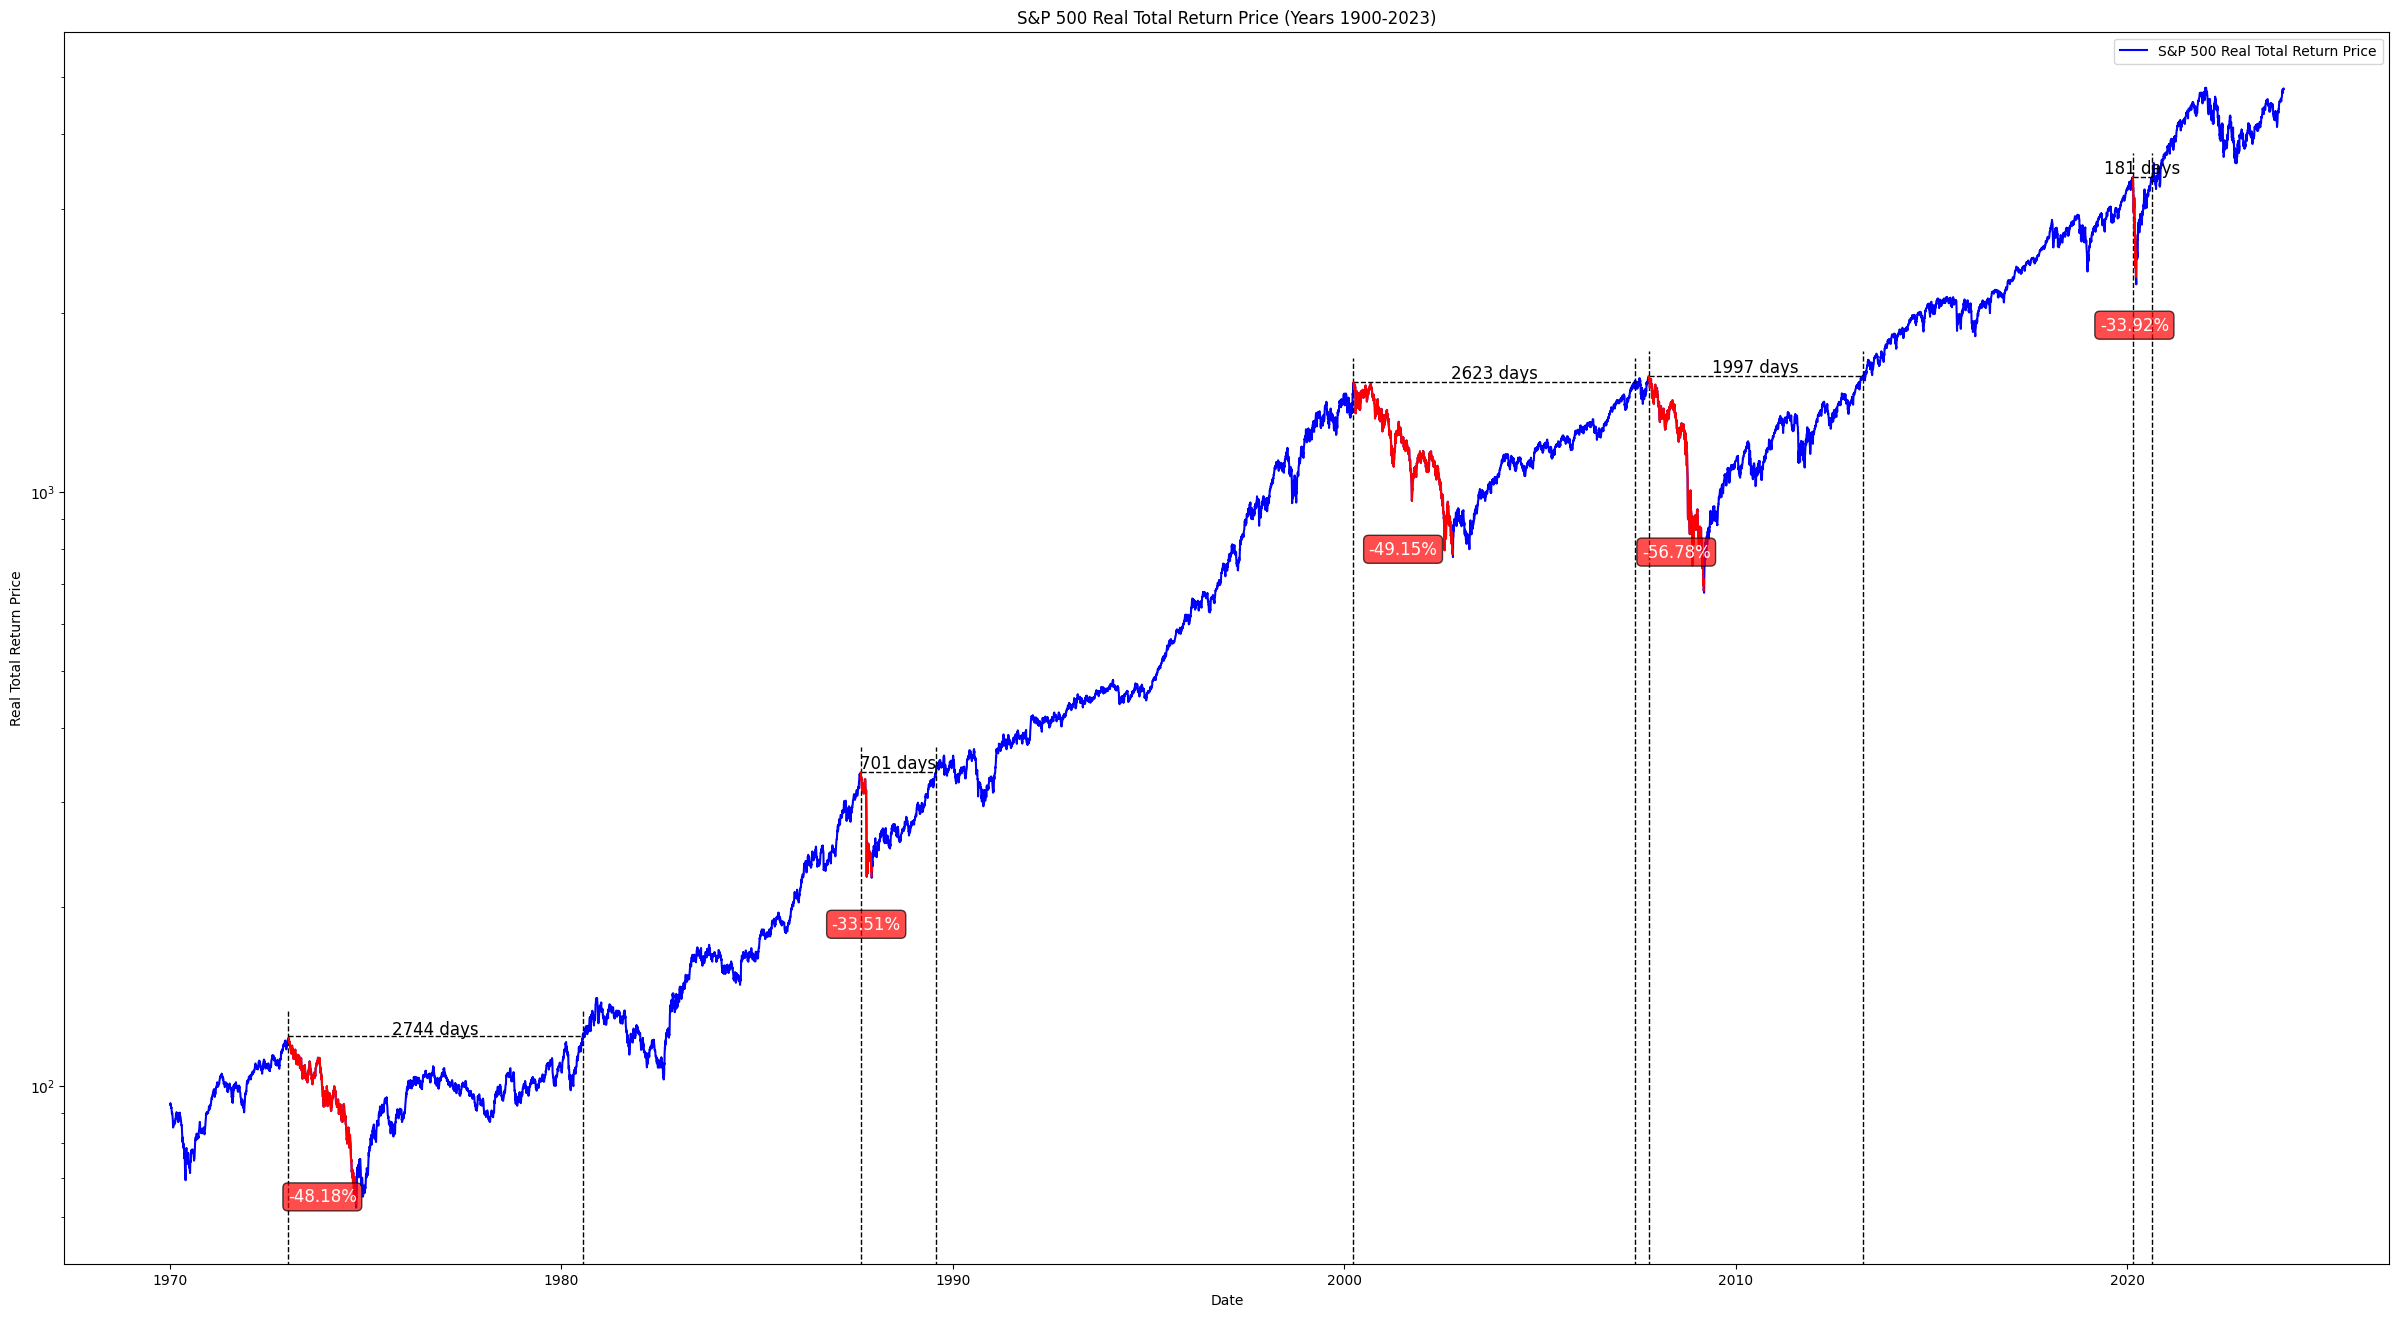

In [27]:

import pandas as pd

# Load the CSV file
# file_path = 'S&P500RealReturns.csv'
# sp500_data = pd.read_csv(file_path)

# # Display the first few rows of the dataframe to understand its structure
# sp500_data.head()
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
info = []
# Function to plot each 30-year period starting from 1900 with text annotation for all drawdowns
def createShapes(sp500_data, start_year, end_year):
    """
    Plots the S&P 500 Real Total Return Price for a 30-year period starting from 1900.
    Highlights entire drawdown periods in red, annotates the duration of all drawdowns, and continues until recovery back to the pre-drawdown peak.
    """
    period_data = sp500_data[(sp500_data['Date'].dt.year >= start_year) & (sp500_data['Date'].dt.year <= end_year)]
    # print(period_data.shape[0])
    plt.figure(figsize=(30, 16))
    plt.yscale('log')
    plt.plot(period_data['Date'], period_data['Real Total Return Price'], label='S&P 500 Real Total Return Price', color="blue")

    # Initialize variables to track drawdowns and recovery
    drawdown_start = None
    peak_before_drawdown = None
    index_of_first_occurrence = None
    low_index = None  # Initialize to None
    
    drawdown_start_indexs = []
    low_indexs=[]
    end_indexes = []
    for index, row in period_data.iterrows():
        if row['Drawdown 30%+'] and drawdown_start is None:
            # Drawdown starts
            bottom_index = index
            index_of_first_occurrence = (period_data['Running Max'] == row['Running Max']).idxmax()
            drawdown_start = index_of_first_occurrence
            if drawdown_start not in drawdown_start_indexs:
                drawdown_start_indexs.append(drawdown_start)
                # print(row)
            peak_before_drawdown = period_data.loc[index, 'Running Max']
            start_date = row["Date"].strftime("%m/%y")
        elif drawdown_start is not None and row['Real Total Return Price'] >= peak_before_drawdown:
            # Drawdown ends (price recovers to the pre-drawdown peak)
            end_date = row["Date"].strftime("%m/%y")
            duration = period_data.loc[index]['Date'] - period_data.loc[drawdown_start]['Date']
            end_indexes.append(index)
            mid_point = period_data.loc[index_of_first_occurrence:index-1, 'Date'].mean()
            low_point_series = period_data.iloc[index_of_first_occurrence:drawdown_start-1]['Real Total Return Price']
            
            plt.text(mid_point, peak_before_drawdown, f'{duration.days} days', fontsize=12, ha='center', va='bottom', color='black')
            plt.hlines(y=row['Real Total Return Price'] , xmin=period_data.loc[drawdown_start-1, 'Date'], xmax=period_data.loc[index, 'Date'], colors='black', linestyles='dashed', lw=1)
            plt.vlines(x=period_data.loc[drawdown_start-1, 'Date'], ymin=0, ymax=row['Real Total Return Price']*1.1, colors='black', linestyles='dashed', lw=1)
            plt.vlines(x=period_data.loc[index, 'Date'], ymin=0, ymax=row['Real Total Return Price']*1.1, colors='black', linestyles='dashed', lw=1)

            drawdown_start = None
            peak_before_drawdown = None
    print(drawdown_start_indexs)
    print(low_indexs)
    print(end_indexes)
    
    for index,value in enumerate(drawdown_start_indexs):
        # print(index,len(drawdown_start_indexs))
        start_index  = value
        end_index = end_indexes[index]
        minVal=period_data.loc[start_index:end_index,'Real Total Return Price'].idxmin()
        # print(start_index,end_index)
        if index == 0:
            # plt.fill_between(period_data.loc[0:start_index-1, 'Date'], period_data.loc[0:start_index-1, 'Real Total Return Price'], color='blue', alpha=0.3)
            pass
        if index == len(drawdown_start_indexs)-1:
            new_index= period_data.index[-1]
            
        else:
            new_index = drawdown_start_indexs[index+1]
            
        # if index+1 < len(drawdown_start_indexs):
        
        end_index = end_indexes[index]
        minVal = period_data.loc[start_index:end_index, 'Real Total Return Price'].idxmin()
        print('Start:'+period_data.loc[start_index, 'Date'].strftime("%d/%m/%y"))
        print('End:'+period_data.loc[end_index, 'Date'].strftime("%d/%m/%y"))
        print('minVal:'+period_data.loc[minVal, 'Date'].strftime("%d/%m/%y"))
        print('NewIndex:'+period_data.loc[new_index, 'Date'].strftime("%d/%m/%y"))
        
        
        print('----------')
        peakValue = period_data.loc[start_index, 'Real Total Return Price']
        lowValue = period_data.loc[minVal, 'Real Total Return Price']
        RecvoveryValue = period_data.loc[end_index, 'Real Total Return Price']
        
        peakDate = period_data.loc[start_index, 'Date']
        lowDate = period_data.loc[minVal, 'Date']
        RecvoveryDate = period_data.loc[end_index, 'Date']
        
        lossDelta =lowDate- peakDate
        LossPeriod= lossDelta.days
        LossPer = round(((peakValue-lowValue)/peakValue)*100,2)
    
        
        reoveryDelta =RecvoveryDate- lowDate
        recvoveryPeriod = reoveryDelta.days
        recoveryPer = ((lowValue-peakValue)/lowValue)*100
        
        totalPeroid =LossPeriod + recvoveryPeriod
        
        
        res = {
            'Peak Date':peakDate.strftime("%d/%m/%Y"),
            'Low Date':lowDate.strftime("%d/%m/%Y"),
            'Loss Period':LossPeriod,
            'Loss %':-LossPer,
            'Recovery Date':RecvoveryDate.strftime("%d/%m/%Y"),
            'Recovery Period':recvoveryPeriod,
            'Recovery %':-recoveryPer,
            'Total Duration':totalPeroid
              }
        info.append(res)
        print(res)
        

        
        print(peakValue,lowValue,RecvoveryValue)
        # print(period_data.loc[start_index, 'Date'])
        # Fill blue section
        blue_start_price = period_data.loc[minVal, 'Real Total Return Price']
        blue_end_price = period_data.loc[new_index, 'Real Total Return Price']
        blue_return = (blue_end_price - blue_start_price) / blue_start_price * 100
        # plt.fill_between(period_data.loc[minVal:new_index-1, 'Date'], period_data.loc[minVal:new_index-1, 'Real Total Return Price'], color='blue', alpha=0.3)
        blue_mid_point_x = period_data.loc[minVal:new_index-1, 'Date'].mean()
        # blue_mid_point_y = period_data.loc[minVal:new_index-1, 'Real Total Return Price'].mean()
        # plt.text(blue_mid_point_x, blue_mid_point_y, f'{blue_return:.2f}%', fontsize=12, ha='center', va='center', color='black')
        
        # Fill red section
        red_start_price = period_data.loc[start_index, 'Real Total Return Price']
        red_end_price = period_data.loc[minVal, 'Real Total Return Price']
        red_return = (red_end_price - red_start_price) / red_start_price * 100
        # plt.fill_between(period_data.loc[start_index:minVal-1, 'Date'], period_data.loc[start_index:minVal-1, 'Real Total Return Price'], color='red', alpha=0.7)
        red_mid_point = period_data.loc[start_index:minVal-1, 'Date'].mean()     
        
        blue_y_values = period_data.loc[minVal:new_index-1, 'Real Total Return Price']
        blue_mid_point_y = np.exp(np.mean(np.log(blue_y_values)))/2

        red_y_values = period_data.loc[start_index:minVal-1, 'Real Total Return Price']
        red_mid_point_y = np.exp(np.mean(np.log(red_y_values)))/1.5
        text_props_red = dict(boxstyle='round', facecolor='red', alpha=0.7)
        text_props_blue = dict(boxstyle='round', facecolor='blue', alpha=0.7)
        # Now use blue_mid_point_y and red_mid_point_y for placing text
        # plt.text(blue_mid_point_x, blue_mid_point_y, f'{blue_return:.2f}%', fontsize=12, ha='center', va='center', color='white',bbox=text_props_blue)
        plt.text(red_mid_point, red_mid_point_y, f'{red_return:.2f}%', fontsize=12, ha='center', va='center', color='white',bbox=text_props_red)

        plt.plot(period_data.loc[start_index:minVal-1, 'Date'],
                      period_data.loc[start_index:minVal-1, 'Real Total Return Price'],color='red')

        

    # plt.fill_between(period_data['Date'], period_data['Real Total Return Price'], where=~period_data['Drawdown 30%+'], color='white', alpha=0.3, label='Other Periods')
    plt.title(f'S&P 500 Real Total Return Price (Years {start_year}-{end_year})')
    plt.xlabel('Date')
    plt.ylabel('Real Total Return Price')
    plt.legend()
    # plt.grid(True)
    plt.savefig('Drawdowns-Log.png')
    plt.show()

# Plot each 30-year period starting from 1900 with text annotation for all drawdowns
start_year = 1900
end_year = min(start_year+123, 2023)
createShapes(sp500_data, start_year, end_year)
# for start_year in range(start_year, 1980, 123):



In [29]:
df = pd.DataFrame(info)

print(df)

  Peak Date  Low Date  Loss Period  Loss % Recovery Date  Recovery Period  \
0  11/01/73  03/10/74          630  -48.18      17/07/80             2114   
1  25/08/87  04/12/87          101  -33.51      26/07/89              600   
2  24/03/00  09/10/02          929  -49.15      30/05/07             1694   
3  09/10/07  09/03/09          517  -56.78      28/03/13             1480   
4  19/02/20  23/03/20           33  -33.92      18/08/20              148   

   Recovery %  Total Duration  
0   92.982567            2744  
1   50.397460             701  
2   96.645031            2623  
3  131.349675            1997  
4   51.343079             181  


In [31]:
df.to_csv('S&P_Data.csv', index=False)

## 

In [2]:
# app.py
from flask import Flask, jsonify
import pandas as pd
from flask import Flask
import threading


app = Flask(__name__)

# Load the CSV file into a DataFrame
# Make sure to replace 'S&P500RealReturns.csv' with the correct path to your CSV file
# sp500_data = pd.read_csv('S&P500RealReturns.csv')
# sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])

# API endpoint to get the data
@app.route('/api/sp500_data', methods=['GET'])
def get_sp500_data():
    # Convert DataFrame to JSON
    data_json = sp500_data.to_json(orient='records', date_format='iso')
    return prepare_chart_data(sp500_data, start_year, end_year)





In [3]:
# Step 2: Define a function to run the app
def run_app():
    # Use 0.0.0.0 to make the server available externally as well, not just locally
    app.run(port=5000, host='0.0.0.0')

# Step 3: Run the app in a background thread
thread = threading.Thread(target=run_app)
# Setting daemon to True will allow the thread to be automatically killed when the main program exits
thread.daemon = True
thread.start()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.178.29:5000
Press CTRL+C to quit


In [4]:
import pandas as pd
import numpy as np

def prepare_chart_data(sp500_data, start_year, end_year):
    period_data = sp500_data[(sp500_data['Date'].dt.year >= start_year) & (sp500_data['Date'].dt.year <= end_year)]
    segments = []  # To hold the data segments with color info

    drawdown_start = None
    drawdown_end = None
    for index, row in period_data.iterrows():
        if row['Drawdown 30%+'] and drawdown_start is None:
            # Start of a drawdown period
            drawdown_start = index
        elif not row['Drawdown 30%+'] and drawdown_start is not None:
            # End of a drawdown period
            drawdown_end = index
            # Add the drawdown segment in red
            segments.append({
                "name": f"Drawdown {period_data.loc[drawdown_start, 'Date'].strftime('%Y-%m-%d')} to {period_data.loc[drawdown_end, 'Date'].strftime('%Y-%m-%d')}",
                "data": period_data.loc[drawdown_start:drawdown_end].apply(lambda row: {"x": row['Date'].strftime('%Y-%m-%d'), "y": row['Real Total Return Price']}, axis=1).tolist(),
                "color": "#000000"
            })
            drawdown_start = None  # Reset for the next drawdown period

        if drawdown_end is not None and index > drawdown_end:
            # Recovery period until the next drawdown starts or data ends
            next_drawdown_start = period_data[index:].apply(lambda row: row['Drawdown 30%+'], axis=1).idxmax() if period_data[index:]['Drawdown 30%+'].any() else period_data.index[-1]
            segments.append({
                "name": f"Recovery {period_data.loc[drawdown_end, 'Date'].strftime('%Y-%m-%d')} to {period_data.loc[next_drawdown_start, 'Date'].strftime('%Y-%m-%d')}",
                "data": period_data.loc[drawdown_end:next_drawdown_start].apply(lambda row: {"x": row['Date'].strftime('%Y-%m-%d'), "y": row['Real Total Return Price']}, axis=1).tolist(),
                "color": "blue"
            })
            drawdown_end = None  # Reset for the next recovery period

    return segments


[2024-02-04 16:56:44,150] ERROR in app: Exception on /api/sp500_data [GET]
Traceback (most recent call last):
  File "C:\Users\MarcoJohnSodefi\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\MarcoJohnSodefi\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\MarcoJohnSodefi\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\MarcoJohnSodefi\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
prepare_chart_data(sp500_data, start_year, end_year)